# THE DES DATA SET #

Purpose of the following document is to inspect the contents of DESI and DES cross matched data. The raw data sets contain SNIa and Host galaxy coordinates that have been corss matched to d2d < 30 arcseconds. 

The data set further refines the galaxy SNIa pairs to be matched with a delta_z < 0.05. 


In [1]:
from astropy.io import fits
from astropy.table import Table

# Load the file
fits_path = "DES_matches_multiHDU.fits"
with fits.open(fits_path) as hdul:
    # Print HDU summary
    print("🔎 HDU Summary:\n")
    hdul.info()

    # Print primary header
    print("\n🧾 Primary Header:")
    print(hdul[0].header)

    # If there's only one table HDU (typically HDU[1]), print its content
    if len(hdul) > 1 and isinstance(hdul[1], fits.BinTableHDU):
        table = Table(hdul[1].data)
        print("\n📋 Column Names in Table HDU:")
        print(table.colnames)

        print("\n👀 Preview of First 5 Rows:")
        print(table[:5])
    else:
        print("\n⚠️ No recognizable table found in HDU[1]. You may want to inspect manually.")

🔎 HDU Summary:

Filename: DES_matches_multiHDU.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  SNIA_MATCHES    1 BinTableHDU    205   90R x 98C   [16A, 16A, I, I, D, D, E, I, I, J, J, J, J, E, E, E, E, E, E, I, I, E, E, I, I, K, I, E, E, E, E, D, D, E, E, E, E, E, E, E, E, E, E, E, E, K, E, K, E, E, E, E, E, E, E, E, K, I, E, E, E, E, D, D, E, E, E, E, E, E, E, E, E, E, E, K, E, K, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, J, D, K, D]   
  2  DESI_MATCHES    1 BinTableHDU    282   90R x 136C   [K, 7A, 6A, J, J, D, D, K, D, 10D, K, 6A, 20A, K, D, J, D, D, E, E, E, K, B, 3A, D, J, I, 8A, J, J, 4A, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, I, E, E, E, E, K, 2A, E, E, E, E, 1A, K, K, K, K, K, K, K, K, K, K, K, K, K, K, K, K, K, K, K, D, D, I, E, I, I, E, E, E, E, E, D, E, D, E, D, D, D, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, I, L, I, L, I, L, 22

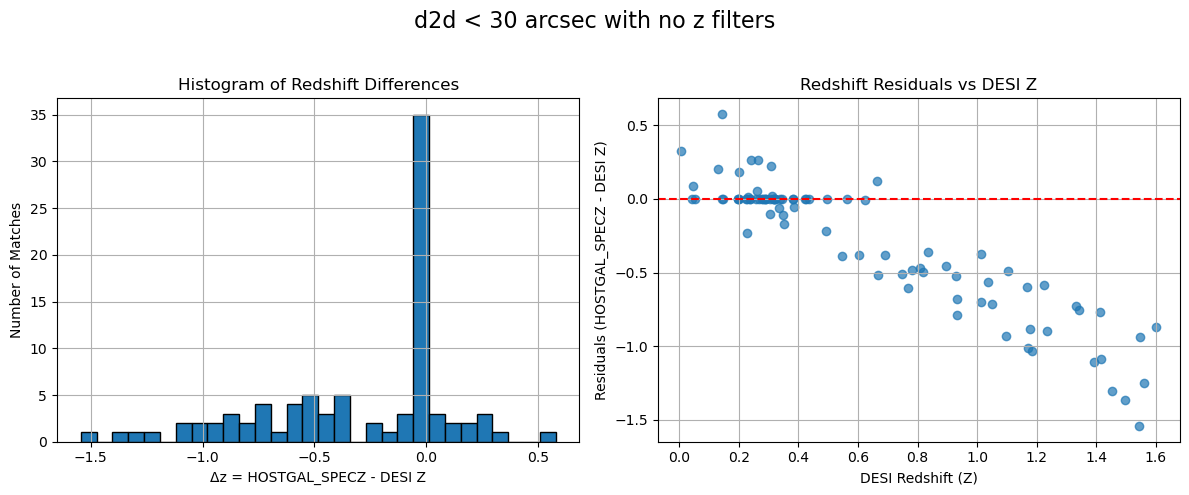

In [2]:
import matplotlib.pyplot as plt

# Load SNIa and DESI matches from the multi-HDU FITS file
fits_path = "DES_matches_multiHDU.fits"
snia_matches = Table.read(fits_path, hdu="SNIA_MATCHES")
desi_matches = Table.read(fits_path, hdu="DESI_MATCHES")

# Prepare data
snia_z = snia_matches["HOSTGAL_SPECZ"]
desi_z = desi_matches["Z"]
# Compute redshift difference
delta_z = snia_matches["HOSTGAL_SPECZ"] - desi_matches["Z"]

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# --- Plot 1: Histogram of Redshift Differences ---
axes[0].hist(delta_z, bins=30, edgecolor='black')
axes[0].set_xlabel("Δz = HOSTGAL_SPECZ - DESI Z")
axes[0].set_ylabel("Number of Matches")
axes[0].set_title("Histogram of Redshift Differences")
axes[0].grid(True)

# --- Plot 2: Residuals vs DESI Redshift ---
axes[1].scatter(desi_z, delta_z, alpha=0.7)
axes[1].axhline(0, color='r', linestyle='--')
axes[1].set_xlabel("DESI Redshift (Z)")
axes[1].set_ylabel("Residuals (HOSTGAL_SPECZ - DESI Z)")
axes[1].set_title("Redshift Residuals vs DESI Z")
axes[1].grid(True)

# Add overarching title
fig.suptitle("d2d < 30 arcsec with no z filters", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for suptitle
plt.show()

✅ Number of clean SNIa-DESI matches (|Δz| ≤ 0.05): 36


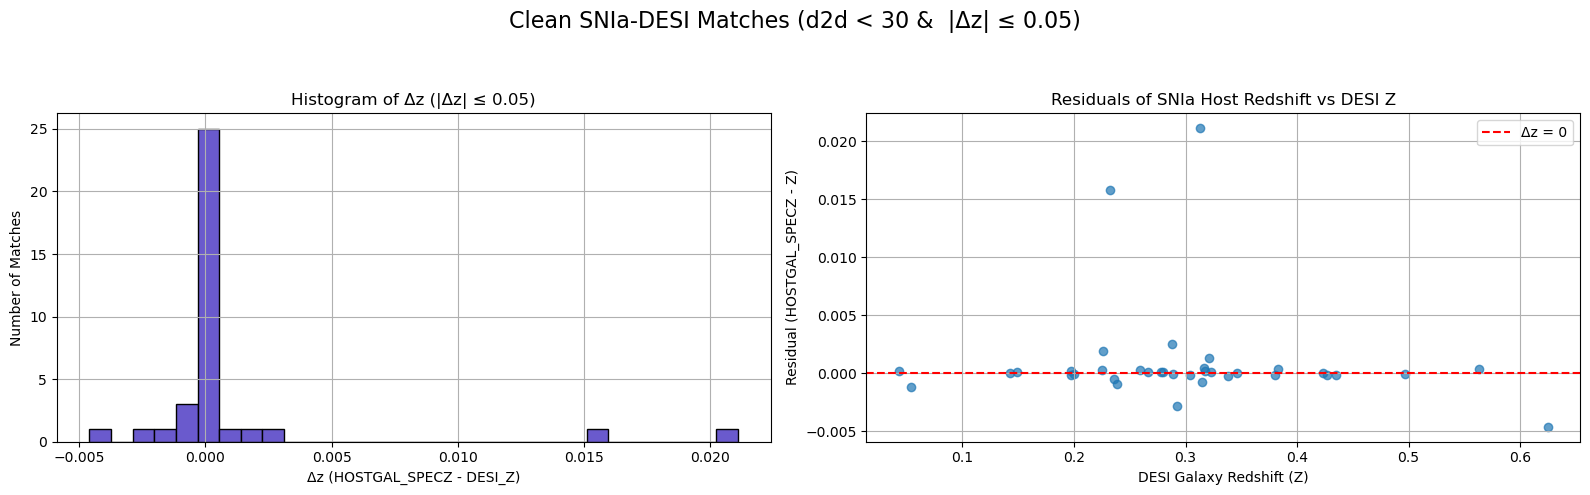

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table

# Compute redshift difference
snia_z = snia_matches["HOSTGAL_SPECZ"]
desi_z = desi_matches["Z"]
delta_z = snia_z - desi_z

# Filter: |Δz| <= 0.05
mask = np.abs(delta_z) <= 0.05
filtered_snia = snia_matches[mask]
filtered_desi = desi_matches[mask]

print(f"✅ Number of clean SNIa-DESI matches (|Δz| ≤ 0.05): {len(filtered_snia)}")

# Save filtered subset to new FITS
primary_hdu = fits.PrimaryHDU()
snia_hdu = fits.BinTableHDU(data=filtered_snia, name="SNIA_CLEAN")
desi_hdu = fits.BinTableHDU(data=filtered_desi, name="DESI_CLEAN")
hdulist = fits.HDUList([primary_hdu, snia_hdu, desi_hdu])
hdulist.writeto("des_desi_matches_d2d_30_delz_0.05.fits", overwrite=True)

# Compute residuals
residuals = filtered_snia["HOSTGAL_SPECZ"] - filtered_desi["Z"]

# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# --- Plot 1: Histogram of Δz ---
axes[0].hist(delta_z[mask], bins=30, color="slateblue", edgecolor="black")
axes[0].set_xlabel("Δz (HOSTGAL_SPECZ - DESI_Z)")
axes[0].set_ylabel("Number of Matches")
axes[0].set_title("Histogram of Δz (|Δz| ≤ 0.05)")
axes[0].grid(True)

# --- Plot 2: Residuals vs DESI Redshift ---
axes[1].scatter(filtered_desi["Z"], residuals, alpha=0.7)
axes[1].axhline(0, color='r', linestyle='--', label='Δz = 0')
axes[1].set_xlabel("DESI Galaxy Redshift (Z)")
axes[1].set_ylabel("Residual (HOSTGAL_SPECZ - Z)")
axes[1].set_title("Residuals of SNIa Host Redshift vs DESI Z")
axes[1].legend()
axes[1].grid(True)

# Add overarching title
fig.suptitle("Clean SNIa-DESI Matches (d2d < 30 &  |Δz| ≤ 0.05)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.92])  # Adjust layout to fit title
plt.show()

SNID         DESI_ID              d2d (arcsec)    R_half (arcsec)   d2d / R_half   SN_z       Host_z     Δz        
----------------------------------------------------------------------------------------------------
1503024      39627628528801157    0.195           2.986             0.07           0.2769     0.2779     -0.0009   
1367571      39627658593567802    0.316           1.081             0.29           0.4331     0.4345     -0.0014   
1530193      39627658610351469    0.334           3.062             0.11           0.1480     0.1488     -0.0008   
1488053      2846795591843840     0.314           0.000             inf            0.0423     0.0430     -0.0007   
1674054      39627640562259122    26.938          2.191             12.30          0.0522     0.0542     -0.0020   
1298893      39627634547622962    0.169           1.877             0.09           0.1962     0.1973     -0.0011   
1310395      39627622547721149    15.480          1.141             13.56          0.28

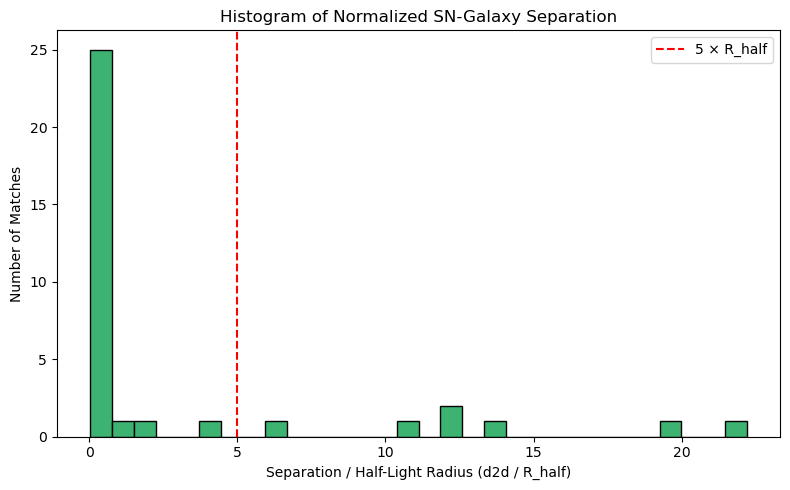

✅ Retained 28 SNIa-DESI matches with d2d/R_half <= 5.
💾 Saved filtered matches to: des_desi_matches_d2d_30_delz_0.05_dDLR_5.fits


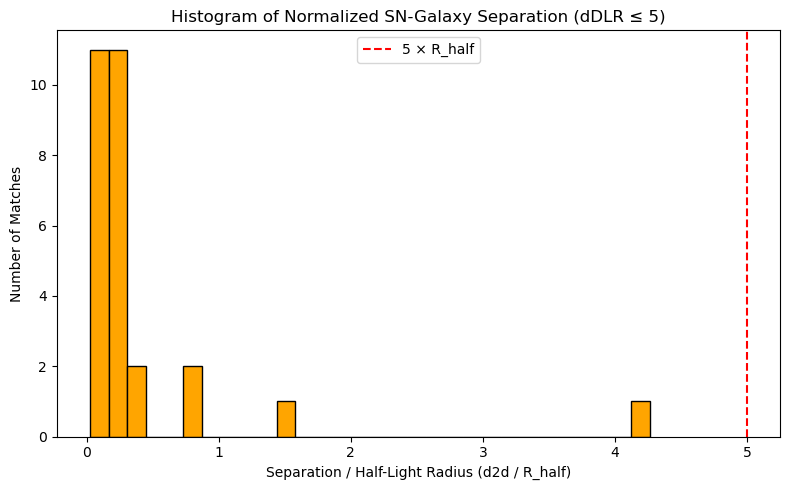

In [12]:
from astropy.io import fits
from astropy.table import Table, hstack
import matplotlib.pyplot as plt
import numpy as np

# Load multi-HDU matched file
fits_path = "des_desi_matches_d2d_30_delz_0.05.fits"

# Read in SNIa and DESI tables
snia_matches = Table.read(fits_path, hdu="SNIA_CLEAN")
desi_matches = Table.read(fits_path, hdu="DESI_CLEAN")

# Extract relevant columns
d2d_arcsec = snia_matches["ANG_SEP_ARCSEC"]  # Angular separation in arcsec
shape_r = desi_matches["SHAPE_R"]            # Half-light radius in arcsec

# Calculate ratio of separation to half-light radius (dDLR)
# Avoid divide-by-zero by marking non-positive values as inf
valid_mask = shape_r > 0
separation_ratio = np.full_like(d2d_arcsec, np.nan, dtype=np.float64)
separation_ratio[valid_mask] = d2d_arcsec[valid_mask] / shape_r[valid_mask]

# Set values to inf where not valid (you could also use np.nan)
separation_ratio[~valid_mask] = float('inf')

# Add this new computed column to snia_matches
snia_matches["D2D_OVER_RHALF"] = separation_ratio

# Extract redshift quantities for later (for printing and plotting)
snia_z = snia_matches["REDSHIFT_FINAL"]
desi_z = desi_matches["Z"]
delta_z = snia_z - desi_z

# Print table for sanity check
print(f"{'SNID':<12} {'DESI_ID':<20} {'d2d (arcsec)':<15} {'R_half (arcsec)':<17} {'d2d / R_half':<14} {'SN_z':<10} {'Host_z':<10} {'Δz':<10}")
print("-" * 100)
for i in range(len(snia_matches)):
    print(f"{snia_matches['SNID'][i]:<12} "
          f"{desi_matches['TARGETID'][i]:<20} "
          f"{d2d_arcsec[i]:<15.3f} "
          f"{shape_r[i]:<17.3f} "
          f"{separation_ratio[i]:<14.2f} "
          f"{snia_z[i]:<10.4f} "
          f"{desi_z[i]:<10.4f} "
          f"{delta_z[i]:<10.4f}")

# Plot histogram of the computed ratio
plt.figure(figsize=(8, 5))
plt.hist(separation_ratio[np.isfinite(separation_ratio)], bins=30, color='mediumseagreen', edgecolor='black')
plt.xlabel("Separation / Half-Light Radius (d2d / R_half)")
plt.ylabel("Number of Matches")
plt.title("Histogram of Normalized SN-Galaxy Separation")
plt.axvline(5, color='red', linestyle='--', label="5 × R_half")
plt.legend()
plt.tight_layout()
plt.show()

# ----- Filtering step -----
# Now use the proper column ("D2D_OVER_RHALF") for filtering
mask = snia_matches["D2D_OVER_RHALF"] <= 5
filtered_snia = snia_matches[mask]
filtered_desi = desi_matches[mask]

print(f"✅ Retained {len(filtered_snia)} SNIa-DESI matches with d2d/R_half <= 5.")

# Save the filtered subset into a new FITS file
output_file = "des_desi_matches_d2d_30_delz_0.05_dDLR_5.fits"
primary_hdu = fits.PrimaryHDU()
snia_hdu = fits.BinTableHDU(data=filtered_snia, name="SNIA_CLEAN")
desi_hdu = fits.BinTableHDU(data=filtered_desi, name="DESI_CLEAN")
hdulist = fits.HDUList([primary_hdu, snia_hdu, desi_hdu])
hdulist.writeto(output_file, overwrite=True)

print(f"💾 Saved filtered matches to: {output_file}")



# Load filtered FITS file
fits_path = "des_desi_matches_d2d_30_delz_0.05_dDLR_5.fits"
snia_filtered = Table.read(fits_path, hdu="SNIA_CLEAN")

# Extract the D2D / R_half ratio
dDLR = snia_filtered["D2D_OVER_RHALF"]

# Remove any non-finite values
clean_dDLR = dDLR[np.isfinite(dDLR)]

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(clean_dDLR, bins=30, color='orange', edgecolor='black')
plt.xlabel("Separation / Half-Light Radius (d2d / R_half)")
plt.ylabel("Number of Matches")
plt.title("Histogram of Normalized SN-Galaxy Separation (dDLR ≤ 5)")
plt.axvline(5, color='red', linestyle='--', label="5 × R_half")
plt.legend(loc='upper center')
plt.tight_layout()
plt.show()

# The Foundation Data Set #

In [5]:
from astropy.io import fits
from astropy.table import Table

# Load the file
fits_path = "foundation_desi_matches_multiHDU.fits"
with fits.open(fits_path) as hdul:
    # Print HDU summary
    print("🔎 HDU Summary:\n")
    hdul.info()

    # Print primary header
    print("\n🧾 Primary Header:")
    print(hdul[0].header)

    # If there's only one table HDU (typically HDU[1]), print its content
    if len(hdul) > 1 and isinstance(hdul[1], fits.BinTableHDU):
        table = Table(hdul[1].data)
        print("\n📋 Column Names in Table HDU:")
        print(table.colnames)

        print("\n👀 Preview of First 5 Rows:")
        print(table[:5])
    else:
        print("\n⚠️ No recognizable table found in HDU[1]. You may want to inspect manually.")

🔎 HDU Summary:

Filename: foundation_desi_matches_multiHDU.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  SNIA_MATCHES    1 BinTableHDU    203   68R x 97C   [16A, 16A, I, I, D, D, E, I, I, J, J, J, J, E, E, E, E, E, E, I, I, E, E, I, I, K, I, E, E, E, E, D, D, E, E, E, E, E, E, E, E, E, E, E, E, K, E, K, E, E, E, E, E, E, E, E, K, I, E, E, E, E, D, D, E, E, E, E, E, E, E, E, E, E, E, K, E, K, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, J, K, D]   
  2  DESI_MATCHES    1 BinTableHDU    282   68R x 136C   [K, 7A, 6A, J, J, D, D, K, D, 10D, K, 6A, 20A, K, D, J, D, D, E, E, E, K, B, 3A, D, J, I, 8A, J, J, 4A, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, I, E, E, E, E, K, 2A, E, E, E, E, 1A, K, K, K, K, K, K, K, K, K, K, K, K, K, K, K, K, K, K, K, D, D, I, E, I, I, E, E, E, E, E, D, E, D, E, D, D, D, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, I, L, I, L,

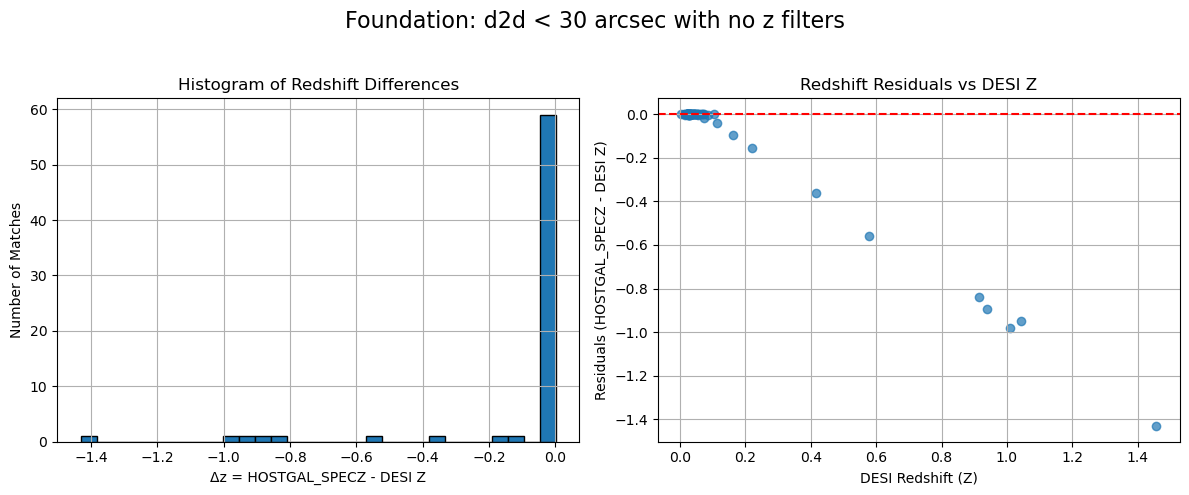

In [13]:
import matplotlib.pyplot as plt
from astropy.table import Table

# === Load Foundation match file ===
fits_path = "foundation_desi_matches_multiHDU.fits"

# Load SNIa and DESI matches from the multi-HDU FITS file
snia_matches = Table.read(fits_path, hdu="SNIA_MATCHES")
desi_matches = Table.read(fits_path, hdu="DESI_MATCHES")

# Extract redshifts
snia_z = snia_matches["REDSHIFT_FINAL"]
desi_z = desi_matches["Z"]

# Compute redshift difference
delta_z = snia_z - desi_z

# === Plot: Histogram + Residuals ===
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# --- Plot 1: Histogram of Δz ---
axes[0].hist(delta_z, bins=30, edgecolor='black')
axes[0].set_xlabel("Δz = HOSTGAL_SPECZ - DESI Z")
axes[0].set_ylabel("Number of Matches")
axes[0].set_title("Histogram of Redshift Differences")
axes[0].grid(True)

# --- Plot 2: Δz vs DESI Z ---
axes[1].scatter(desi_z, delta_z, alpha=0.7)
axes[1].axhline(0, color='r', linestyle='--')
axes[1].set_xlabel("DESI Redshift (Z)")
axes[1].set_ylabel("Residuals (HOSTGAL_SPECZ - DESI Z)")
axes[1].set_title("Redshift Residuals vs DESI Z")
axes[1].grid(True)

# Add overarching title
fig.suptitle("Foundation: d2d < 30 arcsec with no z filters", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

✅ Number of clean SNIa-DESI matches (|Δz| ≤ 0.05): 59


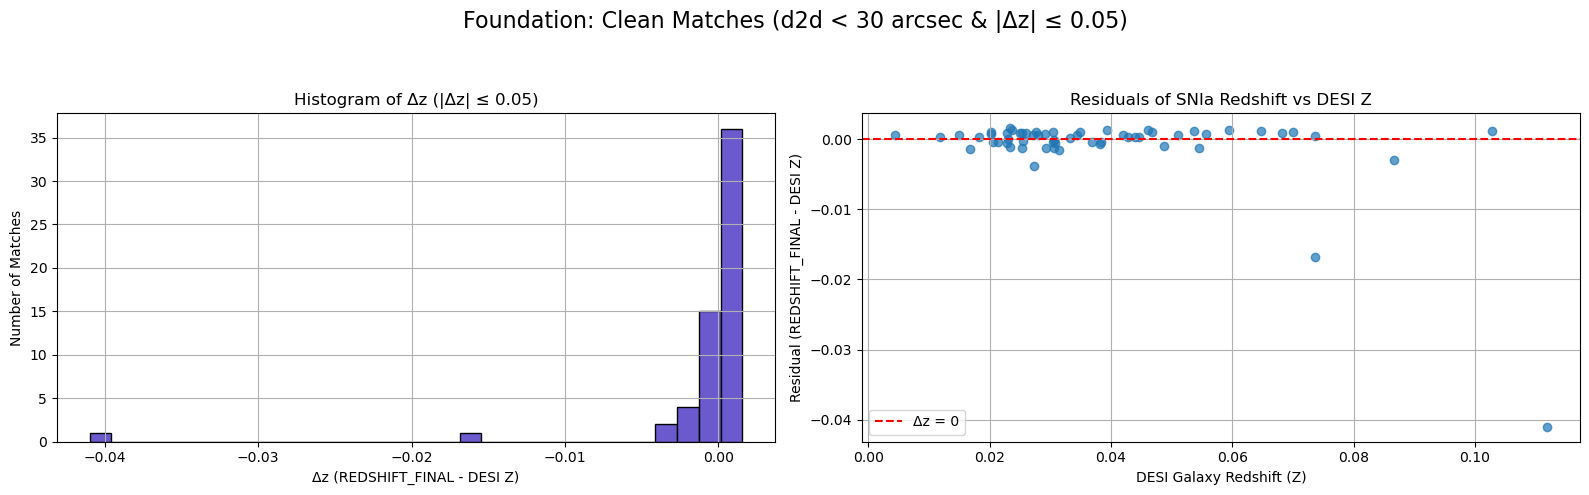

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table

# === Load Foundation match file ===
fits_path = "foundation_desi_matches_multiHDU.fits"
snia_matches = Table.read(fits_path, hdu="SNIA_MATCHES")
desi_matches = Table.read(fits_path, hdu="DESI_MATCHES")

# === Use REDSHIFT_FINAL instead of HOSTGAL_SPECZ ===
snia_z = snia_matches["REDSHIFT_FINAL"]
desi_z = desi_matches["Z"]

# Compute redshift difference
delta_z = snia_z - desi_z

# Filter: |Δz| <= 0.05
mask = np.abs(delta_z) <= 0.05
filtered_snia = snia_matches[mask]
filtered_desi = desi_matches[mask]

print(f"✅ Number of clean SNIa-DESI matches (|Δz| ≤ 0.05): {len(filtered_snia)}")

# Save filtered subset to new FITS
primary_hdu = fits.PrimaryHDU()
snia_hdu = fits.BinTableHDU(data=filtered_snia, name="SNIA_CLEAN")
desi_hdu = fits.BinTableHDU(data=filtered_desi, name="DESI_CLEAN")
hdulist = fits.HDUList([primary_hdu, snia_hdu, desi_hdu])
hdulist.writeto("foundation_filtered_matches_d2d30_delz005.fits", overwrite=True)

# Compute residuals
residuals = filtered_snia["REDSHIFT_FINAL"] - filtered_desi["Z"]

# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# --- Plot 1: Histogram of Δz ---
axes[0].hist(delta_z[mask], bins=30, color="slateblue", edgecolor="black")
axes[0].set_xlabel("Δz (REDSHIFT_FINAL - DESI Z)")
axes[0].set_ylabel("Number of Matches")
axes[0].set_title("Histogram of Δz (|Δz| ≤ 0.05)")
axes[0].grid(True)

# --- Plot 2: Residuals vs DESI Redshift ---
axes[1].scatter(filtered_desi["Z"], residuals, alpha=0.7)
axes[1].axhline(0, color='r', linestyle='--', label='Δz = 0')
axes[1].set_xlabel("DESI Galaxy Redshift (Z)")
axes[1].set_ylabel("Residual (REDSHIFT_FINAL - DESI Z)")
axes[1].set_title("Residuals of SNIa Redshift vs DESI Z")
axes[1].legend()
axes[1].grid(True)

# Add overarching title
fig.suptitle("Foundation: Clean Matches (d2d < 30 arcsec & |Δz| ≤ 0.05)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()

SNID         DESI_ID              d2d (arcsec)    R_half (arcsec)   d2d/R_half     SN_z       Host_z     Δz        
----------------------------------------------------------------------------------------------------
ASASSN-15bc  39627569078734155    3.516           9.290             0.38           0.0364     0.0368     -0.0004   
ASASSN-15la  2843337044262914     1.186           0.000             inf            0.0284     0.0279     0.0005    
ASASSN-15lg  39627872607930329    1.620           9.998             0.16           0.0212     0.0202     0.0010    
ASASSN-15mf  39627860788381837    3.759           2.339             1.61           0.0269     0.0260     0.0009    
ASASSN-15mg  39633109620100561    1.743           7.262             0.24           0.0431     0.0428     0.0002    
ASASSN-15mi  39633104813427009    2.599           1.652             1.57           0.0350     0.0344     0.0006    
ASASSN-15nq  39632951931045868    4.998           1.742             2.87           0.03

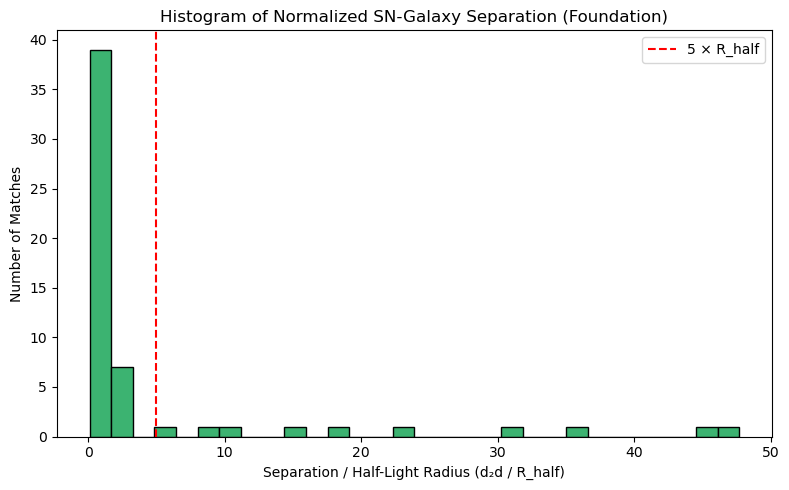

✅ Retained 46 Foundation SNIa-DESI matches with d₂d/R_half <= 5.
💾 Saved filtered Foundation matches to: foundation_desi_matches_d2d_30_delz_0.05_dDLR_5.fits


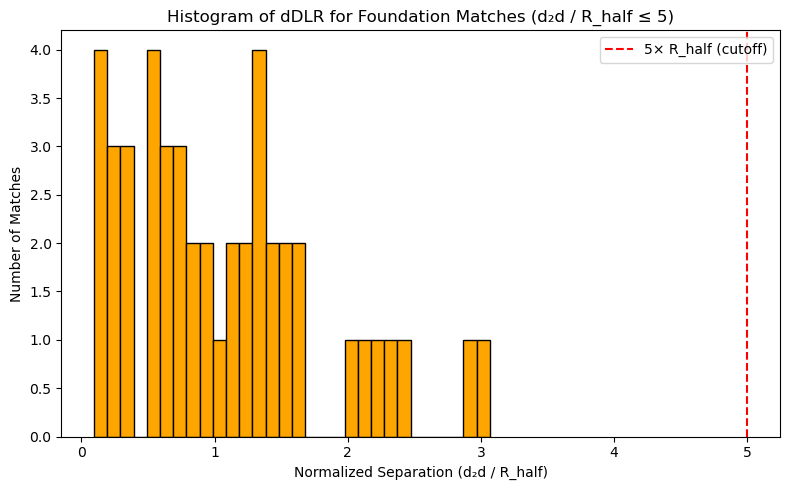

In [17]:
from astropy.io import fits
from astropy.table import Table, hstack
import matplotlib.pyplot as plt
import numpy as np

# ======================================================
# 1. Load the Foundation Matched FITS File
# ======================================================
# Adjust the filename if necessary (here we assume it was saved as follows)
fits_path = "foundation_desi_matches_multiHDU.fits"

# Read in the Foundation SNIa and DESI tables
foundation_snia = Table.read(fits_path, hdu="SNIA_MATCHES")
foundation_desi = Table.read(fits_path, hdu="DESI_MATCHES")

# ======================================================
# 2. Compute the normalized separation (d₂d / R_half)
# ======================================================
# Extract the angular separation (d2d in arcsec) and the galaxy half-light radius (R_half in arcsec)
d2d_arcsec = foundation_snia["ANG_SEP_ARCSEC"]
shape_r = foundation_desi["SHAPE_R"]

# Compute the ratio; first, make sure to avoid divide-by-zero:
valid_mask = shape_r > 0
# Create an array (of type float) that will hold the ratio
separation_ratio = np.full_like(d2d_arcsec, np.nan, dtype=np.float64)
separation_ratio[valid_mask] = d2d_arcsec[valid_mask] / shape_r[valid_mask]
# For any invalid (zero or negative R), set the ratio to infinity (or you could use np.nan)
separation_ratio[~valid_mask] = float('inf')

# Add the computed ratio as a new column to the SNIa table
foundation_snia["D2D_OVER_RHALF"] = separation_ratio

# ======================================================
# 3. Extract redshift quantities (for print/plot later)
# ======================================================
# Here we use REDSHIFT_FINAL as the SN redshift (adjust if needed)
snia_z = foundation_snia["REDSHIFT_FINAL"]
desi_z = foundation_desi["Z"]
delta_z = snia_z - desi_z

# ======================================================
# 4. Print a Summary of the Data
# ======================================================
print(f"{'SNID':<12} {'DESI_ID':<20} {'d2d (arcsec)':<15} {'R_half (arcsec)':<17} "
      f"{'d2d/R_half':<14} {'SN_z':<10} {'Host_z':<10} {'Δz':<10}")
print("-" * 100)
for i in range(len(foundation_snia)):
    print(f"{foundation_snia['SNID'][i]:<12} "
          f"{foundation_desi['TARGETID'][i]:<20} "
          f"{d2d_arcsec[i]:<15.3f} "
          f"{shape_r[i]:<17.3f} "
          f"{separation_ratio[i]:<14.2f} "
          f"{snia_z[i]:<10.4f} "
          f"{desi_z[i]:<10.4f} "
          f"{delta_z[i]:<10.4f}")

# ======================================================
# 5. Plot Histogram of the Unfiltered Normalized Separation
# ======================================================
plt.figure(figsize=(8, 5))
plt.hist(separation_ratio[np.isfinite(separation_ratio)], bins=30, color='mediumseagreen', edgecolor='black')
plt.xlabel("Separation / Half-Light Radius (d₂d / R_half)")
plt.ylabel("Number of Matches")
plt.title("Histogram of Normalized SN-Galaxy Separation (Foundation)")
plt.axvline(5, color='red', linestyle='--', label="5 × R_half")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# ======================================================
# 6. Apply the dDLR Filter: Keep only matches with d₂d/R_half <= 5
# ======================================================
mask = foundation_snia["D2D_OVER_RHALF"] <= 5
filtered_snia = foundation_snia[mask]
filtered_desi = foundation_desi[mask]
print(f"✅ Retained {len(filtered_snia)} Foundation SNIa-DESI matches with d₂d/R_half <= 5.")

# Save the filtered subset into a new multi-HDU FITS file
output_file = "foundation_desi_matches_d2d_30_delz_0.05_dDLR_5.fits"
primary_hdu = fits.PrimaryHDU()
snia_hdu = fits.BinTableHDU(data=filtered_snia, name="SNIA_CLEAN")
desi_hdu = fits.BinTableHDU(data=filtered_desi, name="DESI_CLEAN")
hdulist = fits.HDUList([primary_hdu, snia_hdu, desi_hdu])
hdulist.writeto(output_file, overwrite=True)
print(f"💾 Saved filtered Foundation matches to: {output_file}")

# ======================================================
# 7. Plot Histogram of the Filtered Normalized Separation
# ======================================================
# Reload the filtered SNIa table to ensure using the saved version
filtered_snia = Table.read(output_file, hdu="SNIA_CLEAN")
filtered_dDLR = filtered_snia["D2D_OVER_RHALF"]

finite_mask = np.isfinite(filtered_dDLR)
clean_dDLR = filtered_dDLR[finite_mask]

plt.figure(figsize=(8, 5))
plt.hist(clean_dDLR, bins=30, color="orange", edgecolor="black")
plt.xlabel("Normalized Separation (d₂d / R_half)")
plt.ylabel("Number of Matches")
plt.title("Histogram of dDLR for Foundation Matches (d₂d / R_half ≤ 5)")
plt.axvline(5, color='red', linestyle='--', label="5× R_half (cutoff)")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# The Low-Z Data Set #

In [6]:
from astropy.io import fits
from astropy.table import Table

# Load the file
fits_path = "lowz_desi_matches_multiHDU.fits"
with fits.open(fits_path) as hdul:
    # Print HDU summary
    print("🔎 HDU Summary:\n")
    hdul.info()

    # Print primary header
    print("\n🧾 Primary Header:")
    print(hdul[0].header)

    # If there's only one table HDU (typically HDU[1]), print its content
    if len(hdul) > 1 and isinstance(hdul[1], fits.BinTableHDU):
        table = Table(hdul[1].data)
        print("\n📋 Column Names in Table HDU:")
        print(table.colnames)

        print("\n👀 Preview of First 5 Rows:")
        print(table[:5])
    else:
        print("\n⚠️ No recognizable table found in HDU[1]. You may want to inspect manually.")

🔎 HDU Summary:

Filename: lowz_desi_matches_multiHDU.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  SNIA_MATCHES    1 BinTableHDU    505   105R x 248C   [40A, 16A, 16A, I, I, D, D, E, I, I, J, J, J, J, E, E, E, E, E, E, I, I, E, E, I, I, K, I, E, E, E, E, D, D, E, E, E, E, E, E, E, E, E, E, E, E, K, E, K, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, K, I, E, E, E, E, D, D, E, E, E, E, E, E, E, E, E, E, E, K, E, K, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, J, K, D]   
  2  DESI_MATCHES

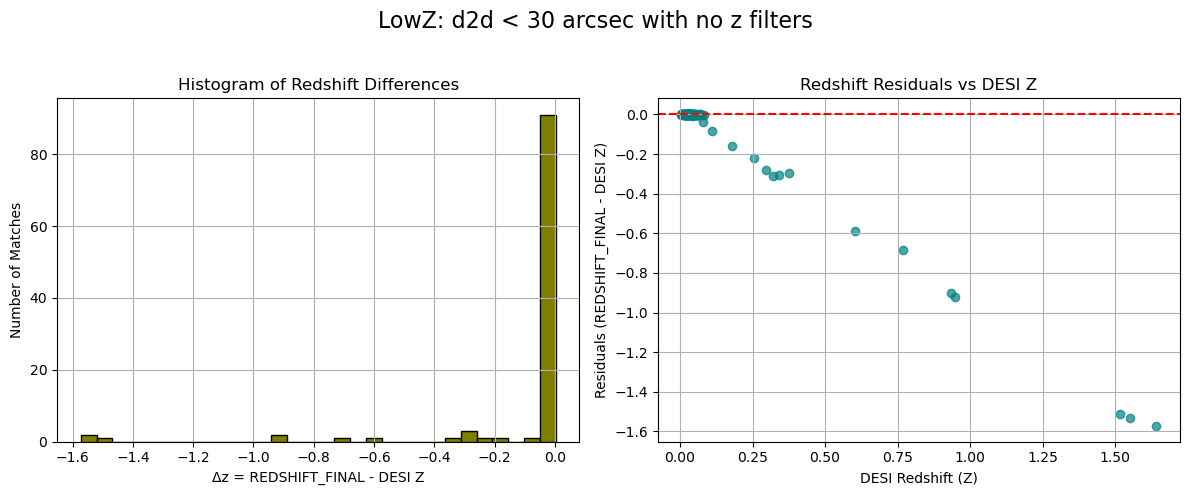

In [18]:
import matplotlib.pyplot as plt
from astropy.table import Table

# === Load LowZ match file ===
fits_path = "lowz_desi_matches_multiHDU.fits"
snia_matches = Table.read(fits_path, hdu="SNIA_MATCHES")
desi_matches = Table.read(fits_path, hdu="DESI_MATCHES")

# Extract redshifts
snia_z = snia_matches["REDSHIFT_FINAL"]
desi_z = desi_matches["Z"]

# Compute Δz
delta_z = snia_z - desi_z

# === Plot: Histogram + Residuals ===
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# --- Plot 1: Histogram of Δz ---
axes[0].hist(delta_z, bins=30, edgecolor='black', color="olive")
axes[0].set_xlabel("Δz = REDSHIFT_FINAL - DESI Z")
axes[0].set_ylabel("Number of Matches")
axes[0].set_title("Histogram of Redshift Differences")
axes[0].grid(True)

# --- Plot 2: Δz vs DESI Z ---
axes[1].scatter(desi_z, delta_z, alpha=0.7, color="teal")
axes[1].axhline(0, color='r', linestyle='--')
axes[1].set_xlabel("DESI Redshift (Z)")
axes[1].set_ylabel("Residuals (REDSHIFT_FINAL - DESI Z)")
axes[1].set_title("Redshift Residuals vs DESI Z")
axes[1].grid(True)

# Add overarching title
fig.suptitle("LowZ: d2d < 30 arcsec with no z filters", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

✅ Number of clean LowZ-DESI matches (|Δz| ≤ 0.05): 91


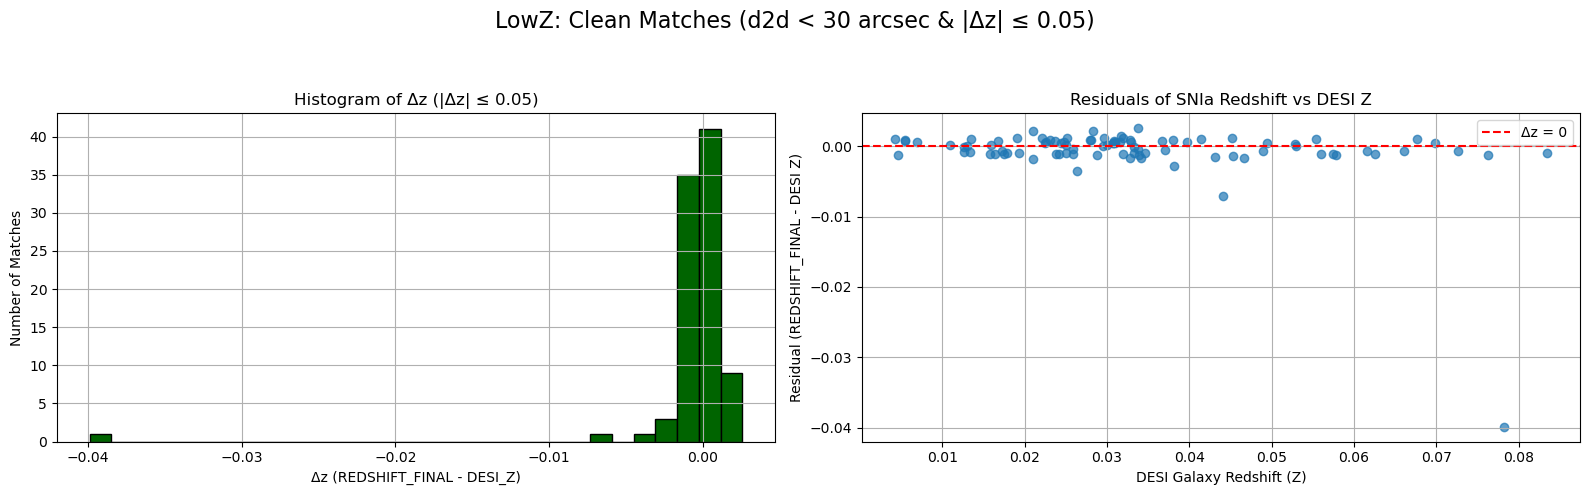

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table

# === Load LowZ match file ===
fits_path = "lowz_desi_matches_multiHDU.fits"
snia_matches = Table.read(fits_path, hdu="SNIA_MATCHES")
desi_matches = Table.read(fits_path, hdu="DESI_MATCHES")

# === Use REDSHIFT_FINAL instead of HOSTGAL_SPECZ ===
snia_z = snia_matches["REDSHIFT_FINAL"]
desi_z = desi_matches["Z"]

# Compute redshift difference
delta_z = snia_z - desi_z

# Filter: |Δz| <= 0.05
mask = np.abs(delta_z) <= 0.05
filtered_snia = snia_matches[mask]
filtered_desi = desi_matches[mask]

print(f"✅ Number of clean LowZ-DESI matches (|Δz| ≤ 0.05): {len(filtered_snia)}")

# Save filtered subset to new FITS
primary_hdu = fits.PrimaryHDU()
snia_hdu = fits.BinTableHDU(data=filtered_snia, name="SNIA_CLEAN")
desi_hdu = fits.BinTableHDU(data=filtered_desi, name="DESI_CLEAN")
hdulist = fits.HDUList([primary_hdu, snia_hdu, desi_hdu])
hdulist.writeto("lowz_filtered_matches_d2d30_delz005.fits", overwrite=True)

# Compute residuals
residuals = filtered_snia["REDSHIFT_FINAL"] - filtered_desi["Z"]

# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# --- Plot 1: Histogram of Δz ---
axes[0].hist(delta_z[mask], bins=30, color="darkgreen", edgecolor="black")
axes[0].set_xlabel("Δz (REDSHIFT_FINAL - DESI_Z)")
axes[0].set_ylabel("Number of Matches")
axes[0].set_title("Histogram of Δz (|Δz| ≤ 0.05)")
axes[0].grid(True)

# --- Plot 2: Residuals vs DESI Redshift ---
axes[1].scatter(filtered_desi["Z"], residuals, alpha=0.7)
axes[1].axhline(0, color='r', linestyle='--', label='Δz = 0')
axes[1].set_xlabel("DESI Galaxy Redshift (Z)")
axes[1].set_ylabel("Residual (REDSHIFT_FINAL - DESI Z)")
axes[1].set_title("Residuals of SNIa Redshift vs DESI Z")
axes[1].legend()
axes[1].grid(True)

# Add overarching title
fig.suptitle("LowZ: Clean Matches (d2d < 30 arcsec & |Δz| ≤ 0.05)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()

SNID         DESI_ID              d2d (arcsec)    R_half (arcsec)   d2d/R_half     SN_z       Host_z     Δz        
----------------------------------------------------------------------------------------------------
2005hc       2402713505628167     6.612           0.000             inf            0.0450     0.0466     -0.0017   
2005hj       39627754890599973    0.596           2.120             0.28           0.0563     0.0574     -0.0011   
2005hk       39627754643134831    19.564          3.354             5.83           0.0118     0.0127     -0.0009   
2005ir       39627803167037706    3.529           3.127             1.13           0.0749     0.0762     -0.0013   
2006ef       39627574543917104    26.122          12.863            2.03           0.0169     0.0179     -0.0009   
2006ej       39627568218901591    24.297          0.000             inf            0.0193     0.0210     -0.0018   
2006ev       39628125235054787    26.074          22.220            1.17           0.02

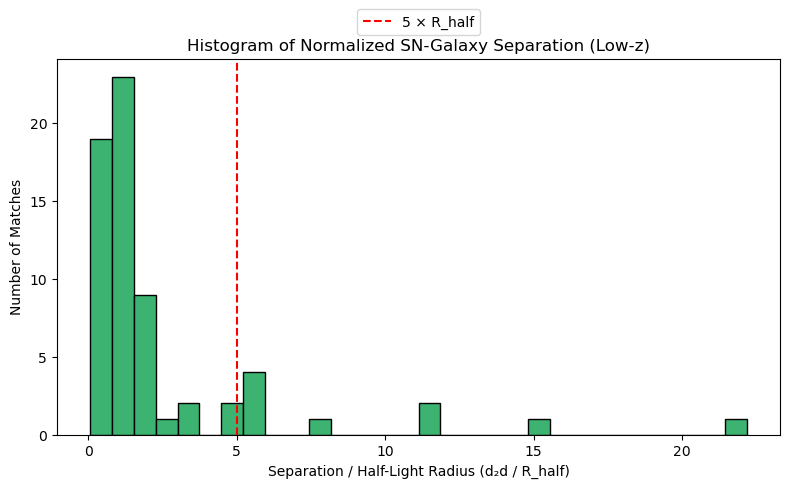

✅ Retained 55 Low-z SNIa-DESI matches with d₂d/R_half <= 5.
💾 Saved filtered Low-z matches to: lowz_desi_matches_d2d_30_delz_0.05_dDLR_5.fits


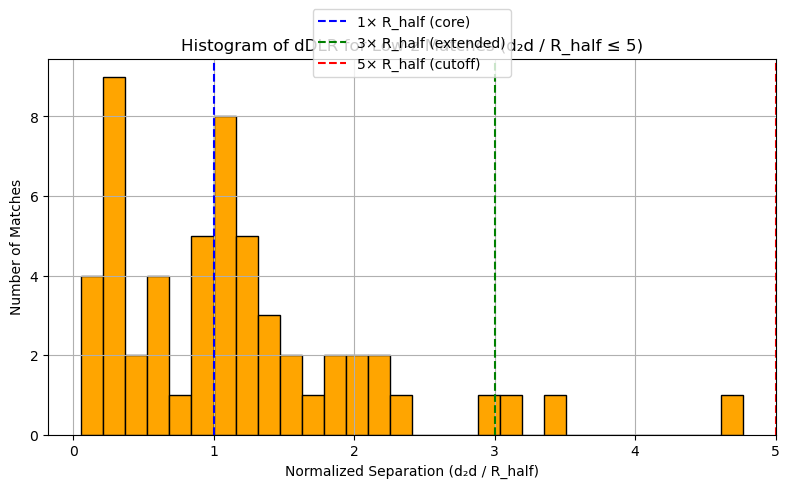

In [23]:
from astropy.io import fits
from astropy.table import Table, hstack
import matplotlib.pyplot as plt
import numpy as np

# ======================================================
# 1. Load the Low-z Multi-HDU Matched File
# ======================================================
fits_path = "lowz_filtered_matches_d2d30_delz005.fits"  # Adjust filename/path as needed

# Read in the Low-z SNIa and DESI tables from their designated HDUs
snia_matches = Table.read(fits_path, hdu="SNIA_CLEAN")
desi_matches = Table.read(fits_path, hdu="DESI_CLEAN")

# ======================================================
# 2. Compute the Normalized Separation (d₂d/R_half)
# ======================================================
# Retrieve the angular separation (d2d, in arcsec) from the SNIa table 
# and the half‑light radius (R_half, in arcsec) from the DESI table
d2d_arcsec = snia_matches["ANG_SEP_ARCSEC"]
shape_r = desi_matches["SHAPE_R"]

# Avoid divide-by-zero by using a mask for valid shape_r values > 0:
valid_mask = shape_r > 0
# Create an array to hold the normalized separation values
separation_ratio = np.full_like(d2d_arcsec, np.nan, dtype=np.float64)
separation_ratio[valid_mask] = d2d_arcsec[valid_mask] / shape_r[valid_mask]
# Set any invalid entries (zero or negative shape_r) to infinity (you could also use np.nan)
separation_ratio[~valid_mask] = float('inf')

# Add the computed ratio as a new column to the SNIa table
snia_matches["D2D_OVER_RHALF"] = separation_ratio

# ======================================================
# 3. Extract Redshifts and Compute Δz
# ======================================================
# Here we assume that "REDSHIFT_FINAL" is used as the SNIa redshift and "Z" is the DESI galaxy redshift.
snia_z = snia_matches["REDSHIFT_FINAL"]
desi_z = desi_matches["Z"]
delta_z = snia_z - desi_z

# ======================================================
# 4. Print a Summary of Key Quantities
# ======================================================
print(f"{'SNID':<12} {'DESI_ID':<20} {'d2d (arcsec)':<15} {'R_half (arcsec)':<17} "
      f"{'d2d/R_half':<14} {'SN_z':<10} {'Host_z':<10} {'Δz':<10}")
print("-" * 100)
for i in range(len(snia_matches)):
    print(f"{snia_matches['SNID'][i]:<12} "
          f"{desi_matches['TARGETID'][i]:<20} "
          f"{d2d_arcsec[i]:<15.3f} "
          f"{shape_r[i]:<17.3f} "
          f"{separation_ratio[i]:<14.2f} "
          f"{snia_z[i]:<10.4f} "
          f"{desi_z[i]:<10.4f} "
          f"{delta_z[i]:<10.4f}")

# ======================================================
# 5. Plot a Histogram of the Unfiltered Normalized Separation
# ======================================================
plt.figure(figsize=(8, 5))
plt.hist(separation_ratio[np.isfinite(separation_ratio)], bins=30, color='mediumseagreen', edgecolor='black')
plt.xlabel("Separation / Half-Light Radius (d₂d / R_half)")
plt.ylabel("Number of Matches")
plt.title("Histogram of Normalized SN-Galaxy Separation (Low-z)")
plt.axvline(5, color='red', linestyle='--', label="5 × R_half")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15))
plt.tight_layout()
plt.show()

# ======================================================
# 6. Apply the dDLR Filter: Retain Only Matches with d₂d/R_half <= 5
# ======================================================
mask = snia_matches["D2D_OVER_RHALF"] <= 5
filtered_snia = snia_matches[mask]
filtered_desi = desi_matches[mask]
print(f"✅ Retained {len(filtered_snia)} Low-z SNIa-DESI matches with d₂d/R_half <= 5.")

# Save the filtered subset to a new multi-HDU FITS file with an appended name
output_file = "lowz_desi_matches_d2d_30_delz_0.05_dDLR_5.fits"
primary_hdu = fits.PrimaryHDU()
snia_hdu = fits.BinTableHDU(data=filtered_snia, name="SNIA_CLEAN")
desi_hdu = fits.BinTableHDU(data=filtered_desi, name="DESI_CLEAN")
hdulist = fits.HDUList([primary_hdu, snia_hdu, desi_hdu])
hdulist.writeto(output_file, overwrite=True)
print(f"💾 Saved filtered Low-z matches to: {output_file}")

# ======================================================
# 7. Plot a Histogram of the Filtered Normalized Separation
# ======================================================
filtered_dDLR = filtered_snia["D2D_OVER_RHALF"]
finite_mask = np.isfinite(filtered_dDLR)
clean_dDLR = filtered_dDLR[finite_mask]

plt.figure(figsize=(8, 5))
plt.hist(clean_dDLR, bins=30, color="orange", edgecolor="black")
plt.xlabel("Normalized Separation (d₂d / R_half)")
plt.ylabel("Number of Matches")
plt.title("Histogram of dDLR for Low-z Matches (d₂d / R_half ≤ 5)")
plt.axvline(1, color='blue', linestyle='--', label="1× R_half (core)")
plt.axvline(3, color='green', linestyle='--', label="3× R_half (extended)")
plt.axvline(5, color='red', linestyle='--', label="5× R_half (cutoff)")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15))
plt.grid(True)
plt.tight_layout()
plt.show()

In [22]:
from astropy.io import fits
from astropy.table import Table

# Path to your FITS file
fits_path = "lowz_filtered_matches_d2d30_delz005.fits"

# Open the FITS file and explore its content
with fits.open(fits_path) as hdul:
    # Print an overall summary of the HDUs
    print("🔎 HDU Summary:\n")
    hdul.info()
    
    # Print the primary header
    print("\n🧾 Primary HDU Header:")
    print(hdul[0].header)
    
    # Loop over all HDUs starting at index 1 (skipping the primary HDU)
    for i in range(1, len(hdul)):
        hdu = hdul[i]
        print(f"\n--- HDU {i}: {hdu.name} ---")
        print("Header:")
        print(hdu.header)
        
        # Check if this HDU is a binary table HDU
        if isinstance(hdu, fits.BinTableHDU):
            # Convert the HDU data into an Astropy Table for easier viewing
            table = Table(hdu.data)
            print("\nColumn Names:")
            print(table.colnames)
            print("\nPreview of the first 5 rows:")
            print(table[:5])
        else:
            print("This HDU is not a binary table and could not be converted into a Table.")

🔎 HDU Summary:

Filename: lowz_filtered_matches_d2d30_delz005.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  SNIA_CLEAN    1 BinTableHDU    505   91R x 248C   [40A, 16A, 16A, I, I, D, D, E, I, I, J, J, J, J, E, E, E, E, E, E, I, I, E, E, I, I, K, I, E, E, E, E, D, D, E, E, E, E, E, E, E, E, E, E, E, E, K, E, K, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, K, I, E, E, E, E, D, D, E, E, E, E, E, E, E, E, E, E, E, K, E, K, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, J, K, D]   
  2  DESI_C